## Verifying causal fairness using Justicia
In this tutorial, we apply Justicia to verify causal fairness, more specifically path-specific causal fairness (PSCF)\[1,2\].  

Path-specific causal fairness states that the outcome of a classifier should not depend directly on a sensitive attribute, but may depend indirectly on sensitive covariates through other <em>mediator covariates</em> that are relevant for prediction.

For example, the outcome of college admission should not rely on the sensitive attribute "sex", but may depend on it indirectly through a mediator covariate "years of experience". To satisfy path-specific causal fairness, the mediator covariate for a minority group (e.g., female) takes valuation as if it belongs to the majority group (e.g., male). Hence, in the hypothetical world, all other attributes of minority group remain same except mediator covariates.


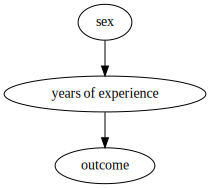

In [1]:
from graphviz import Digraph
dot = Digraph()
dot.edge('sex', 'years of experience')
dot.edge('years of experience', 'outcome')
dot

### Outline of the tutorial
1. Learn a classifier on a dataset
2. Learn majority (most favored) sensitive group using Justicia
3. Define mediator attributes and input along with majority group information to Justicia
4. Verify path-specific causal fairness

In [2]:
# standard library
import sklearn.metrics
from sklearn.model_selection import train_test_split
from pyrulelearn.imli import imli
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import tree
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Markdown, display
import sys
import pandas as pd
sys.path.append("..")

# From this framework
from data.objects.adult import Adult
from data.objects.titanic import Titanic
import justicia.utils
from justicia.metrics import Metric


### Prepare a dataset

In [3]:
verbose = False
dataset = Adult(verbose=verbose, config=0) # config defines configuration for sensitive groups
df = dataset.get_df()
# get X,y
X = df.drop(['target'], axis=1)
y = df['target']
display(Markdown("#### Sensitive attributes"))
print(dataset.known_sensitive_attributes)
display(Markdown("#### Feature matrix"))
print("Before one hot encoding")
X.head()


#### Sensitive attributes

['race', 'sex']


#### Feature matrix

Before one hot encoding


,race,sex,age,education-num,capital-gain,capital-loss,hours-per-week
0,White,Male,0.301370,0.800000,0.02174,0.0,0.397959
1,White,Male,0.452055,0.800000,0.00000,0.0,0.122449
2,White,Male,0.287671,0.533333,0.00000,0.0,0.397959
3,Black,Male,0.493151,0.400000,0.00000,0.0,0.397959
4,Black,Female,0.150685,0.800000,0.00000,0.0,0.397959


In [4]:
# one-hot encoding for categorical features (this takes care of Label encoding automatically)
X = justicia.utils.get_one_hot_encoded_df(X,dataset.categorical_attributes)
print("After->")    
X 

After->


,sex,age,education-num,capital-gain,capital-loss,hours-per-week,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White
0,0,0.301370,0.800000,0.021740,0.0,0.397959,0,0,0,0,1
1,0,0.452055,0.800000,0.000000,0.0,0.122449,0,0,0,0,1
2,0,0.287671,0.533333,0.000000,0.0,0.397959,0,0,0,0,1
3,0,0.493151,0.400000,0.000000,0.0,0.397959,0,0,1,0,0
4,1,0.150685,0.800000,0.000000,0.0,0.397959,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
32556,1,0.136986,0.733333,0.000000,0.0,0.377551,0,0,0,0,1
32557,0,0.315068,0.533333,0.000000,0.0,0.397959,0,0,0,0,1
32558,1,0.561644,0.533333,0.000000,0.0,0.397959,0,0,0,0,1
32559,0,0.068493,0.533333,0.000000,0.0,0.193878,0,0,0,0,1


### Train a classifier

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle = True, random_state=2) # 70% training and 30% test

clf = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=0)
# clf = tree.DecisionTreeClassifier(max_depth=5)
# clf = SVC(kernel="linear")


clf.fit(X_train.values, y_train.values)
print("\nTrain Accuracy:", sklearn.metrics.accuracy_score(clf.predict(X_train.values),y_train.values))
print("Test Accuracy:", sklearn.metrics.accuracy_score(clf.predict(X_test.values),y_test.values))        


Train Accuracy: 0.764946764946765
Test Accuracy: 0.7675775253300583


### Learn most favored group

We now learn the most favored group based on disparte impact and sensitive attributes. This group information is required to verify path-specific causal fairness. More details can be found in tutorial [2](./3\.\ Verifying\ causal\ fairness.ipynb).

In [6]:
metric = Metric(model=clf, data=X_test, sensitive_attributes=dataset.known_sensitive_attributes, verbose=False, encoding="best-correlated")
metric.compute()
print("Sensitive attributes", metric.given_sensitive_attributes)
print("Disparate Impact:", metric.disparate_impact_ratio)
print("Statistical Parity:", metric.statistical_parity_difference)
print("Time taken", metric.time_taken, "seconds")

display(Markdown("#### Most Favored group"))
print((", ").join([" ".join([each_sensitive_attribute[0], each_sensitive_attribute[1][0], str(each_sensitive_attribute[1][1])])  for each_sensitive_attribute in list(metric.most_favored_group.items())]))

Sensitive attributes ['race', 'sex']
Disparate Impact: 0.6044797508650545
Statistical Parity: 0.18962418850272234
Time taken 12.20949101448059 seconds


#### Most Favored group

race_Asian-Pac-Islander == 1, sex != 1


## Verify path-specific causal fairness

We now input metric.most_favored_group as the most favored group to computing path-specific causal fairness. Additionally, we define mediator attributes.

In [7]:
display(Markdown("#### Mediator attributes"))
mediator_attributes = ['education-num', 'capital-gain']
# mediator_attributes = dataset.mediator_attributes
print(mediator_attributes)


metric_pscf = Metric(model=clf, data=X_test, sensitive_attributes=dataset.known_sensitive_attributes, mediator_attributes=mediator_attributes, major_group=metric.most_favored_group, verbose=False, encoding="best-correlated")
metric_pscf.compute()

display(Markdown("#### Path-specific causal results"))
print("Disparate Impact:", metric_pscf.disparate_impact_ratio)
print("Statistical Parity:", metric_pscf.statistical_parity_difference)

display(Markdown("#### Do metrics change in path-specific causal fairness?"))
print("Disparate impact", "increases" if metric.disparate_impact_ratio < metric_pscf.disparate_impact_ratio else ("decreases" if metric.disparate_impact_ratio > metric_pscf.disparate_impact_ratio else 'is equal'))
print("Statistical parity", "increases" if metric.statistical_parity_difference < metric_pscf.statistical_parity_difference else ("decreases" if metric.statistical_parity_difference > metric_pscf.statistical_parity_difference else 'is equal'))


#### Mediator attributes

['education-num', 'capital-gain']


#### Path-specific causal results

Disparate Impact: 0.6321753502054879
Statistical Parity: 0.18956442745975688


#### Do metrics change in path-specific causal fairness?

Disparate impact increases
Statistical parity decreases


Below we show detailed results on positive predictive value (PPV) of the classifier for different sensitive groups. We observe that PPV usually differs when some attributes are considered mediator attributes. 

#### Most Favored group

race_Asian-Pac-Islander == 1, sex != 1


#### Least Favored group

race_Amer-Indian-Eskimo == 1, sex == 1


#### Most Favored group (Causal)

race_Asian-Pac-Islander == 1, sex != 1


#### Least Favored group (Causal)

race_Amer-Indian-Eskimo == 1, sex == 1


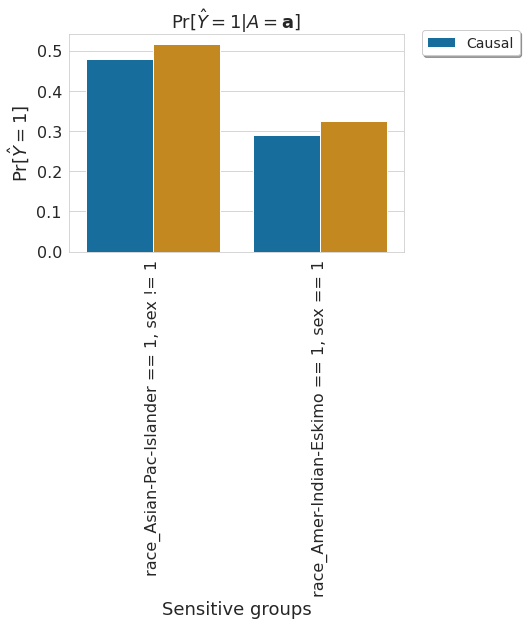

<Figure size 432x288 with 0 Axes>

In [8]:
groups = [(", ").join([" ".join([each_sensitive_attribute[0], each_sensitive_attribute[1][0], str(each_sensitive_attribute[1][1])])  for each_sensitive_attribute in group_info[0]]) for group_info in metric.sensitive_group_statistics]
PPVs = [group_info[1] for group_info in metric.sensitive_group_statistics]




groups_pscf = [(", ").join([" ".join([each_sensitive_attribute[0], each_sensitive_attribute[1][0], str(each_sensitive_attribute[1][1])])  for each_sensitive_attribute in group_info[0]]) for group_info in metric_pscf.sensitive_group_statistics]
PPVs_pscf = [group_info[1] for group_info in metric_pscf.sensitive_group_statistics]


df = pd.DataFrame({
    "Group" : groups + groups_pscf,
    "PPV" : PPVs + PPVs_pscf, 
    'causal' : ["Causal" for _ in range(len(PPVs))] + ["" for _ in range(len(PPVs))]
})

display(Markdown("#### Most Favored group"))
print((", ").join([" ".join([each_sensitive_attribute[0], each_sensitive_attribute[1][0], str(each_sensitive_attribute[1][1])])  for each_sensitive_attribute in list(metric.most_favored_group.items())]))
display(Markdown("#### Least Favored group"))
print((", ").join([" ".join([each_sensitive_attribute[0], each_sensitive_attribute[1][0], str(each_sensitive_attribute[1][1])])  for each_sensitive_attribute in list(metric.least_favored_group.items())]))

display(Markdown("#### Most Favored group (Causal)"))
print((", ").join([" ".join([each_sensitive_attribute[0], each_sensitive_attribute[1][0], str(each_sensitive_attribute[1][1])])  for each_sensitive_attribute in list(metric_pscf.most_favored_group.items())]))
display(Markdown("#### Least Favored group (Causal)"))
print((", ").join([" ".join([each_sensitive_attribute[0], each_sensitive_attribute[1][0], str(each_sensitive_attribute[1][1])])  for each_sensitive_attribute in list(metric_pscf.least_favored_group.items())]))


fontsize = 22
labelsize = 18
sns.set_style("whitegrid", {'axes.grid' : True})
sns.barplot(x='Group', y='PPV', hue='causal', data=df, palette='colorblind')
plt.xticks(fontsize=labelsize-2, rotation=90)
plt.yticks(fontsize=labelsize-2)
plt.ylabel(r"$\Pr[\hat{Y} = 1]$", fontsize=labelsize)
plt.xlabel("Sensitive groups", fontsize=labelsize)
plt.title(r"$\Pr[\hat{Y} = 1 | A=\mathbf{a}]$", fontsize=labelsize)
plt.legend(loc='upper center', fontsize=labelsize-4, bbox_to_anchor=(1.2, 1.05), fancybox=True, shadow=True)
plt.show()
plt.clf()


## References
\[1\] Bastani, Osbert, Xin Zhang, and Armando Solar-Lezama. "Probabilistic verification of fairness properties via concentration." Proceedings of the ACM on Programming Languages 3.OOPSLA (2019): 1-27.

\[2\] Razieh Nabi and Ilya Shpitser. 2018. "Fair inference on outcomes." In Proceedings of AAAI, Vol. 2018. 